In [2]:
from datetime import datetime
from src import config
import hopsworks
import pandas as pd
import logging
import mlflow
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import sys
from pathlib import Path

# Añade src al path para importar los módulos
sys.path.append(str(Path().resolve().parent / 'src'))

DEBUG ENV HOPSWORKS_PROJECT_NAME: fleca_mlops
DEBUG ENV PATH: C:\Workspace\mlops_fleca_project\.env


In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# Configuración básica de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('feature_view_creation')

In [5]:
# Conectar a Hopsworks y al Feature Store
try:
    # Login y conexión al proyecto
    project = hopsworks.login(
        api_key_value=config.HOPSWORKS_API_KEY, 
        project=config.HOPSWORKS_PROJECT_NAME)
    
    # Conexión al feature store
    feature_store = project.get_feature_store()
    
    # Conexión al feature group
    feature_group = feature_store.get_feature_group(
        name=config.FEATURE_GROUP_NAME,
        version=config.FEATURE_GROUP_VERSION
    )
    
    logger.info(f"Conexión exitosa al Feature Group: {feature_group.name} (v{feature_group.version})")
    
except Exception as e:
    logger.error(f"Error en conexión: {e}")
    raise

2025-09-05 10:08:24,363 INFO: Initializing external client
2025-09-05 10:08:24,363 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-09-05 10:08:25,784 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1242272
2025-09-05 10:08:27,117 INFO: Conexión exitosa al Feature Group: times_series_bolleria_feature_group (v1)


In [6]:
# Crear/obtener feature view con características seleccionadas
try:
    # Características específicas a incluir
    selected_features = ['familia', 'base_imponible', 'is_summer_peak', 'is_easter', 'week_start']
    feature_view_name = config.FEATURE_VIEW_NAME
    feature_view_version = 1
    
    # Intentar obtener la feature view existente primero
    try:
        feature_view = feature_store.get_feature_view(
            name=feature_view_name,
            version=feature_view_version
        )
        logger.info(f"Feature view existente recuperada: {feature_view.name} (v{feature_view.version})")
    
    except:
        # Si no existe, crear una nueva
        # Obtener objetos Feature para las características seleccionadas
        selected_feature_objects = [f for f in feature_group.features if f.name in selected_features]
        
        # Crear query con características seleccionadas
        specific_query = feature_group.select(selected_feature_objects)
        
        # Crear la feature view
        feature_view = feature_store.create_feature_view(
            name=feature_view_name,
            version=feature_view_version,
            query=specific_query,
            description=f"Feature view con características: {', '.join(selected_features)}"
        )
        logger.info(f"Nueva feature view creada: {feature_view.name} (v{feature_view.version})")
    
except Exception as e:
    logger.error(f"Error al crear/obtener feature view: {e}")
    raise

2025-09-05 10:08:28,003 INFO: Feature view existente recuperada: times_series_bolleria_feature_view (v1)


In [7]:
# Obtener datos de la feature view
try:
    # Obtener datos en batch normal
    df_ts = feature_view.get_batch_data()
    
    # Mostrar resumen de los datos obtenidos
    logger.info(f"Datos obtenidos: {df_ts.shape[0]} filas, {df_ts.shape[1]} columnas")
    logger.info(f"Columnas disponibles: {list(df_ts.columns)}")
    print("Muestra de datos:")
    print(df_ts.head(3))
    
except Exception as e:
    logger.error(f"Error al obtener datos: {e}")
    raise

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 
2025-09-05 10:08:31,977 INFO: Datos obtenidos: 134 filas, 5 columnas
2025-09-05 10:08:31,979 INFO: Columnas disponibles: ['familia', 'base_imponible', 'is_summer_peak', 'is_easter', 'week_start']
Muestra de datos:
    familia  base_imponible  is_summer_peak  is_easter  \
0  BOLLERIA          641.56               0          0   
1  BOLLERIA          725.72               0          0   
2  BOLLERIA          950.70               0          0   

                 week_start  
0 2023-02-06 00:00:00+00:00  
1 2025-02-24 00:00:00+00:00  
2 2023-09-18 00:00:00+00:00  


In [8]:
# Obtener datos de entrenamiento (training_data)
try:
    # Obtener datos de entrenamiento (X, y) desde la feature view
    df_ts = feature_view.training_data()

except Exception as e:
    print(f"Error al obtener datos de entrenamiento: {e}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 


In [9]:
# Procesar datos para entrenamiento
from src.data_utils import transformar_features_target

try:
       
    # Procesar datos usando la función mejorada que acepta tuplas directamente
    features_and_target = transformar_features_target(
        df_ts,
        lags_list=[1, 2, 3, 52], 
        columna_target='base_imponible',
        cols_exogenas=['is_easter', 'is_summer_peak'],
        periodos_adelante=1,
        eliminar_nulos=True,
        return_format='dataframe'  # Obtenemos un único DataFrame con features y target
    )
    
    # Mostrar información de los datos procesados
    logger.info(f"Datos procesados: {features_and_target.shape[0]} filas, {features_and_target.shape[1]} columnas")
    logger.info(f"Variables disponibles: {list(features_and_target.columns)}")
    print("\nMuestra de datos procesados:")
    print(features_and_target.head(3))
    
except Exception as e:
    logger.error(f"Error al procesar datos: {e}")
    raise

2025-09-05 10:08:35,733 INFO: Detectada entrada tipo tupla con 2 elementos
2025-09-05 10:08:35,733 INFO: Usando el primer elemento de la tupla como DataFrame: (134, 5)
2025-09-05 10:08:35,740 INFO: Retornando DataFrame combinado: (81, 8)
2025-09-05 10:08:35,741 INFO: Datos procesados: 81 filas, 8 columnas
2025-09-05 10:08:35,741 INFO: Variables disponibles: ['base_imponible_lag1', 'base_imponible_lag2', 'base_imponible_lag3', 'base_imponible_lag52', 'is_easter', 'is_summer_peak', 'week_start', 'target']

Muestra de datos procesados:
     base_imponible_lag1  base_imponible_lag2  base_imponible_lag3  \
41                572.51               534.79               563.18   
72                597.65               572.51               534.79   
114               680.30               597.65               572.51   

     base_imponible_lag52  is_easter  is_summer_peak  \
41                 825.11          0               0   
72                 658.40          0               0   
114         

In [10]:
# Split temporal (automático 80/20 ya incluido en la función)
from src.data_split import train_test_split

try:
    X_train, y_train, X_test, y_test = train_test_split(
        features_and_target,
        target='target'  # o 'base_imponible' según tu pipeline
        # split_ratio=0.8  # puedes cambiar el porcentaje si lo necesitas
    )
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
except Exception as e:
    logger.error(f"Error en el split temporal: {e}")
    raise


Train: (65, 7), Test: (16, 7)


In [11]:
# Configuración de MLflow para registrar todo en el servidor web y visualizar en la UI
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment("fleca_bolleria_experiments")

2025-09-05 10:08:37,986 WARNING: Retrying (Retry(total=6, connect=6, read=7, redirect=7, status=7)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000298FA916D40>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=fleca_bolleria_experiments
2025-09-05 10:08:44,073 WARNING: Retrying (Retry(total=5, connect=5, read=7, redirect=7, status=7)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000298FA944310>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=fleca_bolleria_experiments
2025-09-05 10:08:54,409 WARNING: Retrying (Retry(total=4, connect=4, read=7, redirect=7, s

2025/09/05 10:10:54 INFO mlflow.tracking.fluent: Experiment with name 'fleca_bolleria_experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/175554612633604615', creation_time=1757059854276, experiment_id='175554612633604615', last_update_time=1757059854276, lifecycle_stage='active', name='fleca_bolleria_experiments', tags={}>

In [12]:
# Eliminar columnas datetime antes de entrenar
for df in [X_train, X_test]:
    if 'week_start' in df.columns:
        df.drop('week_start', axis=1, inplace=True)

In [13]:
# Importar XGBoost y métricas
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definimos los modelos a entrenar
with mlflow.start_run(run_name="xgboost"):
    # Entrenamos el modelo
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Realizamos predicciones
    predictions = model.predict(X_test)

    # Calcular métricas
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Log de los parámetros
    mlflow.log_param("model", "xgboost")
    for param, value in model.get_params().items():
        mlflow.log_param(param, value)

    # Log de las métricas
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)

    # Log del modelo
    mlflow.xgboost.log_model(model, "model")

    # Imprimir resultados
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")

2025/09/05 10:10:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/05 10:10:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAE: 193.54536376953124
MSE: 54498.652727145265
R2: 0.4845049039371516
🏃 View run xgboost at: http://127.0.0.1:5000/#/experiments/175554612633604615/runs/d67da3fb76fb48f290b7aef88f1493a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/175554612633604615


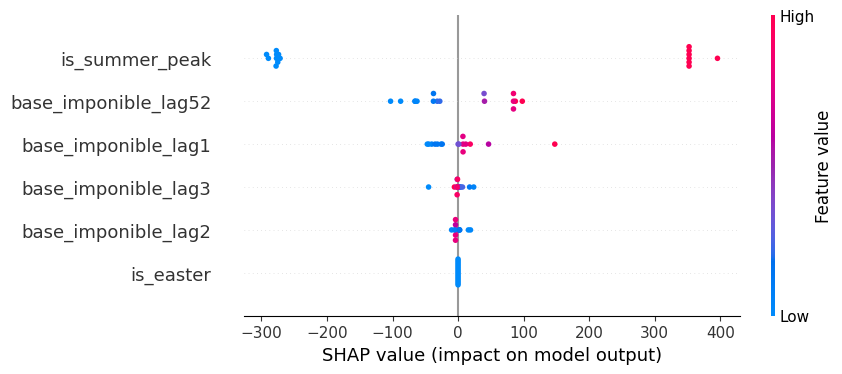

In [14]:
# Interpretabilidad de XGBoost con SHAP
import shap
# Crear objeto explainer para el modelo entrenado
# Esto nos permitirá calcular los valores SHAP para las predicciones
# Usamos el conjunto de entrenamiento para ajustar el explainer
# Esto es necesario para SHAP pueda entender la distribución de los datos
# Nota: Si el conjunto de entrenamiento es muy grande, considera usar una muestra
# Crea el expalainer de SHAP
explainer = shap.Explainer(model.predict, X_test)

# Calcular valores SHAP para el conjunto de prueba
shap_values = explainer(X_test)

# Visualzar
shap.plots.beeswarm(shap_values)

**Interpretación** 

El modelo está fuertemente influenciado por la estacionalidad (is_summer_peak, base_imponible_lag52) y la persistencia temporal (base_imponible_lag1). Las variables base_imponible_lag2 y lag3 aportan menos información, siendo esta última potencialmente prescindible. is_easter muestra un impacto casi nulo.

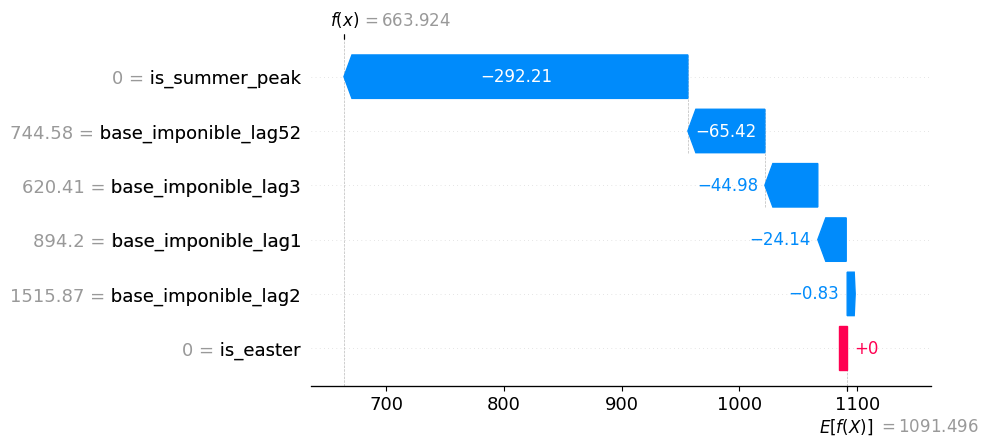

In [16]:
shap.plots.waterfall(shap_values[0])

In [63]:
# Definimos los modelos a entrenar

models ={
    "LinearRegresion": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=100),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100)
    }

In [64]:
# Entrenamos y evaluamos varios modelos a la vez
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # Entrenamos el modelo
        model.fit(X_train, y_train)
        # Realizamos predicciones
        y_pred = model.predict(X_test)

        # Calculamos las métricas
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Registramos las métricas en mlflow
        mlflow.log_metrics({
            "mae": mae,
            "mse": mse,
            "r2": r2_score(y_test, y_pred)
        })
        # Registramos los hiperparámetros en mlflow
        mlflow.log_params({
            "model": model_name,
            "n_estimators": model.n_estimators if hasattr(model, "n_estimators") else None,
            "max_depth": model.max_depth if hasattr(model, "max_depth") else None,
            "learning_rate": model.learning_rate if hasattr(model, "learning_rate") else None
        })

        # Registramos el modelo en mlflow
        mlflow.sklearn.log_model(model, "model")

        logger.info(f"Modelo: {model_name} - MAE: {mae}, MSE: {mse}, R2: {r2}")


2025/08/24 13:08:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 13:08:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-08-24 13:08:41,933 INFO: Modelo: LinearRegresion - MAE: 205.51486658938077, MSE: 63302.69911598183, R2: 0.30649562972125177


2025/08/24 13:08:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LinearRegresion at: http://127.0.0.1:5000/#/experiments/5/runs/f7b95367dfb947b3bc537c1be408341f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5


2025/08/24 13:08:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-08-24 13:08:43,349 INFO: Modelo: Ridge - MAE: 181.89402786424205, MSE: 53159.90578118782, R2: 0.41761366422442714


2025/08/24 13:08:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Ridge at: http://127.0.0.1:5000/#/experiments/5/runs/6ee80be4b3c6483c8570b7a353d7ded1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5


2025/08/24 13:08:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-08-24 13:08:44,790 INFO: Modelo: Lasso - MAE: 205.03036855412086, MSE: 63018.17331888658, R2: 0.30961271456120576


2025/08/24 13:08:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Lasso at: http://127.0.0.1:5000/#/experiments/5/runs/82af7dd5b61546d5ae32291ec7edb506
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5


2025/08/24 13:08:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-08-24 13:08:46,297 INFO: Modelo: RandomForest - MAE: 179.26747999999995, MSE: 52840.631879115994, R2: 0.42111142734503415


2025/08/24 13:08:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/5/runs/2e4c1ecb6ff34f778d1ee9df56566402
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5


2025/08/24 13:08:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-08-24 13:08:47,733 INFO: Modelo: GradientBoosting - MAE: 194.46300570564398, MSE: 59422.45294565838, R2: 0.3490051548198002
🏃 View run GradientBoosting at: http://127.0.0.1:5000/#/experiments/5/runs/3f758d9d527b4400b70685c15d72875a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5


In [66]:
# Buscar el mejor modelo por menor MAE y registrar automáticamente en MLflow Model Registry
import mlflow
from mlflow.tracking import MlflowClient
client = MlflowClient()
experiment = client.get_experiment_by_name('fleca_bolleria_experiments')
runs = client.search_runs(experiment_ids=[experiment.experiment_id], order_by=['metrics.mae ASC'])
best_run = runs[0]  # El de menor MAE
print('Mejor modelo:', best_run.data.params['model'])
print('Run ID del mejor modelo:', best_run.info.run_id)


Mejor modelo: RandomForest
Run ID del mejor modelo: 2e4c1ecb6ff34f778d1ee9df56566402


In [67]:
# Registramos el mejor modelo
# Id del run del mejor modelo (puedes cogerlo de la UI)
run_id = "2e4c1ecb6ff34f778d1ee9df56566402"  # Este es el run_id real
model_uri = f'runs:/{run_id}/model'  # Sintaxis correcta para MLflow
model_description = 'Modelo de Random Forest entrenado con 1,2,3,52 Lags'
mlflow.register_model(model_uri, 'RandomForest')

Successfully registered model 'RandomForest'.
2025/08/24 13:09:38 WARNING mlflow.tracking._model_registry.fluent: Run with id 2e4c1ecb6ff34f778d1ee9df56566402 has no artifacts at artifact path 'model', registering model based on models:/m-ba35a128968c4b91a5792e5e52edc8b2 instead
2025/08/24 13:09:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest, version 1
Created version '1' of model 'RandomForest'.


<ModelVersion: aliases=[], creation_timestamp=1756033778212, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1756033778212, metrics=None, model_id=None, name='RandomForest', params=None, run_id='2e4c1ecb6ff34f778d1ee9df56566402', run_link='', source='models:/m-ba35a128968c4b91a5792e5e52edc8b2', status='READY', status_message=None, tags={}, user_id='', version='1'>

In [36]:
import mlflow
mlflow.set_tracking_uri("file:///c:/Workspace/mlops_fleca_project/mlruns")
mlflow.set_experiment("bolleria_predicts")

with mlflow.start_run() as run:
    import mlflow.sklearn
    mlflow.sklearn.log_model(model, "model", registered_model_name="RandomForest")

2025-08-24 13:04:42,285 WARNING: Malformed experiment '4'. Detailed error Yaml file 'C:\Workspace\mlops_fleca_project\mlruns\4\meta.yaml' does not exist.
Traceback (most recent call last):
  File "c:\Workspace\mlops_fleca_project\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 366, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Workspace\mlops_fleca_project\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 464, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Workspace\mlops_fleca_project\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1634, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Workspace\mlops_fleca_project\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1627, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Workspace\mlops_fleca_project\.venv\l

2025/08/24 13:04:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/24 13:04:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForest' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForest'.


# ESte no funciona (hay que investigar por qué)

In [61]:
# Entrenamiento y evaluación con XGBoost
from src.model import train_evaluate_xgboost

# Eliminar columnas datetime antes de entrenar
for df in [X_train, X_test]:
    if 'week_start' in df.columns:
        df.drop('week_start', axis=1, inplace=True)

with mlflow.start_run(run_name="xgboost"):
    resultados = train_evaluate_xgboost(X_train, y_train, X_test, y_test)
    model = resultados["model"]

    # Log de los parámetros del modelo
    mlflow.log_param("model", "xgboost")
    for param, value in model.get_params().items():
        mlflow.log_param(param, value)

    # Log de las métricas
    mlflow.log_metric("mae", resultados["mae"])
    
    mlflow.log_metric("r2", resultados["r2"])

    # Log del modelo
    mlflow.xgboost.log_model(model, "model")

    # Imprimir resultados
    print(f"MAE: {resultados['mae']}")
   
    print(f"R2: {resultados['r2']}")


2025/08/23 12:24:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/23 12:24:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/23 12:24:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAE: 236.2600927734375
R2: 0.08752420359999014
🏃 View run xgboost at: http://localhost:5000/#/experiments/1/runs/65ddfe3dd1954b21a34ab0388987d4e4
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [18]:
# Ejemplo: cargar el modelo registrado desde el Model Registry
import mlflow

# Cambia 'RandomForest' y versión si corresponde
model_uri = 'models:/RandomForest/1'
model = mlflow.pyfunc.load_model(model_uri)

# Realizar predicciones (ejemplo con X_test)
# y_pred = model.predict(X_test)

print('Modelo cargado desde el Model Registry:', model_uri)

Modelo cargado desde el Model Registry: models:/RandomForest/1
